In [57]:
from collections import Counter
import pandas as pd
import string
from transformers import AutoTokenizer
import spacy
import codecs
import random
import pickle

### Function definitions

In [13]:
def get_pos_tags(doc_path):
    nlp = spacy.load('en_core_web_sm')
    nlp.max_length = 2000000
    pos_dict = {}
    with open(doc_path, 'r', encoding='utf-8') as file:
        text = file.read()
        doc = nlp(text)
        for token in doc:
            if token.text.lower() in pos_dict and not token.pos_ in pos_dict[token.text.lower()]:
                pos_dict[token.text.lower()].append(token.pos_)
            else:
                pos_dict[token.text.lower()] = [token.pos_]
        
    return pd.DataFrame(list(pos_dict.items()), columns=['token', 'POS'])

In [ ]:
def get_sample_sentences(tokenizer, wordbank_file, tokenized_examples_file,
                         max_seq_len, min_seq_len, max_samples, bidirectional=True):
    short_sents = []
    num_long_sents = 0
    num_lines = 0
    # Each entry of token data is a tuple of token, token_id, masked_sample_sentences.
    token_data = []
    # Load words.
    df = pd.read_csv(wordbank_file, sep='\t').dropna().reset_index(drop=True)
    wordbank_tokens = df.token.unique().tolist()
    # Get token ids.
    for token in wordbank_tokens:
        token_id = tokenizer.convert_tokens_to_ids(token)
        if token_id != tokenizer.unk_token_id:
            token_data.append(tuple([token, token_id, []]))
    # Load sentences.
    print(f"Loading sentences from {tokenized_examples_file}.")
    infile = codecs.open(tokenized_examples_file, 'rb', encoding='utf-8')
    for line_count, line in enumerate(infile):
        num_lines += 1
        if line_count % 100000 == 0:
            print("Finished line {}.".format(line_count))
        example_string = line.strip()
        example = [int(token_id) for token_id in example_string.split()]
        # Use the pair of sentences (instead of individual sentences), to have
        # longer sequences. Also more similar to training.
        if len(example) < min_seq_len:
            short_sents.append(example)
            continue
        if len(example) > max_seq_len:
            num_long_sents += 1
            example = example[:max_seq_len]
        for token, token_id, sample_sents in token_data:
            if len(sample_sents) >= max_samples:
                # This token already has enough sentences.
                continue
            token_indices = [index for index, curr_id in enumerate(example) if curr_id == token_id]
            # Warning: in bidirectional contexts, the mask can be in the first or last position,
            # which can cause no mask prediction to be made for the biLSTM.
            if not bidirectional:
                # The token must have enough unidirectional context.
                # The sequence length (including the target token) must be at least min_seq_len.
                token_indices = [index for index in token_indices if index >= min_seq_len-1]
            if len(token_indices) > 0:
                new_example = example.copy()
                mask_idx = random.choice(token_indices)
                new_example[mask_idx] = tokenizer.mask_token_id
                sample_sents.append(new_example)
    infile.close()
    # Logging.
    print(f'{len(short_sents)}/{num_lines} examples were shorter than {min_seq_len} tokens and were thus discarded. {((num_lines-len(short_sents))/num_lines)*100:.2f}% of examples were kept.')
    print(f'{num_long_sents} examples were longer than {max_seq_len} tokens and were thus clipped.')
    return token_data, short_sents

### Creating wordbank file

In [19]:
with open('../data/wikitext/wikitext103_test.txt', 'r') as file:
    words = file.read().split()

df = pd.DataFrame(list(Counter(word.lower() for word in words).items()), columns=['token', 'count']).sort_values('count', ascending=False)
df = df[df['token'].apply(lambda t: t.isascii() and t  not in string.punctuation and t.isalpha())].reset_index(drop=True)
df


,token,count
0,the,16057
1,of,6750
2,and,5793
3,in,5074
4,to,4766
...,...,...
17417,bourgeoisie,1
17418,clerks,1
17419,overruns,1
17420,cleopatra,1


In [20]:
document = "../data/wikitext/wikitext103_test.txt"
pos_tags = get_pos_tags(document)
pos_tags

,token,POS
0,,[SPACE]
1,robert,[PROPN]
2,boulter,[PROPN]
3,is,[AUX]
4,an,[DET]
...,...,...
18746,parlayed,[VERB]
18747,credibility,[NOUN]
18748,ronnie,[PROPN]
18749,pelkey,[PROPN]


In [21]:
merged_df = pd.merge(df, pos_tags, on='token', how='inner').sort_values(['token']).reset_index(drop=True)
merged_df

,token,count,POS
0,a,4030,[DET]
1,aa,16,"[PROPN, NOUN]"
2,aaa,2,[PROPN]
3,aaron,1,[PROPN]
4,aau,1,[PROPN]
...,...,...,...
17414,zumwalt,1,[PROPN]
17415,zweite,1,[PROPN]
17416,zygapophyses,1,[NOUN]
17417,zygosaurus,1,[PROPN]


In [22]:
# These words were not assigned a POS tag and were thus not included in the resulting df
df[~df.token.isin(merged_df.token.tolist())]

,token,count
1202,hed,21
2086,cannot,12
7753,gonna,2


In [23]:
merged_df = merged_df[merged_df.POS.apply(lambda x: x != ['PROPN'])]    # removing proper nouns
merged_df

,token,count,POS
0,a,4030,[DET]
1,aa,16,"[PROPN, NOUN]"
9,abandon,1,[VERB]
10,abandoned,26,[VERB]
11,abandoning,1,[VERB]
...,...,...,...
17406,zoo,2,"[PROPN, NOUN]"
17407,zoom,1,[NOUN]
17408,zooms,1,[NOUN]
17412,zu,2,[NOUN]


In [24]:
# only keeping words that are considered one token by the language model
tokenizer = AutoTokenizer.from_pretrained('google/multiberts-seed_0')
filtered_words = [word for word in merged_df['token'].tolist() if len(tokenizer.tokenize(word)) == 1]
filtered_df = merged_df[merged_df['token'].isin(filtered_words)].reset_index(drop=True)

print(f'Percentage of words that are considered one token by the language model: {((len(filtered_df) / len(merged_df)) * 100):.2f}%')

filtered_df['token_ids'] = filtered_df['token'].apply(lambda t: tokenizer.convert_tokens_to_ids(t))
filtered_df = filtered_df[['token', 'token_ids', 'count', 'POS']]
filtered_df

Percentage of words that are considered one token by the language model: 73.49%


,token,token_ids,count,POS
0,a,1037,4030,[DET]
1,aa,9779,16,"[PROPN, NOUN]"
2,abandon,10824,1,[VERB]
3,abandoned,4704,26,[VERB]
4,abandoning,19816,1,[VERB]
...,...,...,...,...
9075,zone,4224,21,[NOUN]
9076,zones,10019,6,[NOUN]
9077,zoo,9201,2,"[PROPN, NOUN]"
9078,zoom,24095,1,[NOUN]


In [25]:
filtered_df.to_csv('../data/wikitext/wikitext_wordbank.tsv', sep='\t', index=None)

Preprocessing steps:
- removed non-ascii characters, punctuation marks, and digits --> 17,747 tokens
- added POS tags --> 17,686 tokens (61 tokens were not assigned a POS tag and were thus not included in the merged df)
- removed tokens identified only as a proper noun --> 12,501 tokens
- filtered out words that were not considered one token by the language model --> 9,133 tokens

---

### Analyzing the wordbank

<Axes: title={'center': 'Distribution of token counts'}>

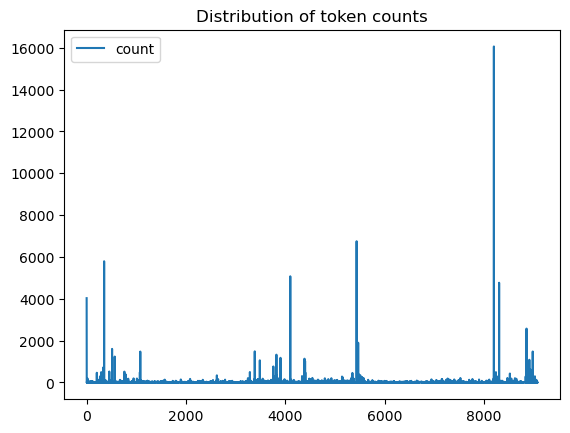

In [26]:
wordbank = pd.read_csv('../data/wikitext/wikitext_wordbank.tsv', sep='\t').dropna().reset_index(drop=True)
wordbank.plot(y='count', title='Distribution of token counts')

In [27]:
highly_frequent = wordbank[wordbank['count'].apply(lambda x: x > 512)]
print(f'{(len(wordbank)-len(highly_frequent))/len(wordbank)*100:.2f}% of tokens had a maximum of 512 samples in the dataset.')
print(f'{len(highly_frequent)/len(wordbank)*100:.2f}% of tokens appeared at least 512 times.')
highly_frequent.sort_values('count', ascending=False)

99.72% of tokens had a maximum of 512 samples in the dataset.
0.28% of tokens appeared at least 512 times.


,token,token_ids,count,POS
8200,the,1996,16057,['DET']
5436,of,1997,6750,['ADP']
352,and,1998,5793,['CCONJ']
4100,in,1999,5074,['ADP']
8305,to,2000,4766,"['ADP', 'PART']"
0,a,1037,4030,['DET']
8857,was,2001,2575,['AUX']
5467,on,2006,1900,['ADP']
512,as,2004,1605,['ADP']
8199,that,2008,1522,"['SCONJ', 'PRON']"


In [28]:
least_frequent = wordbank[wordbank['count'].apply(lambda x: x == 1)]
print(f'{(len(least_frequent))/len(wordbank)*100:.2f}% of tokens had a single sample in the dataset.')
least_frequent

28.19% of tokens had a single sample in the dataset.


,token,token_ids,count,POS
2,abandon,10824,1,['VERB']
4,abandoning,19816,1,['VERB']
5,abandonment,22290,1,['NOUN']
7,abbreviation,22498,1,['NOUN']
8,abdomen,13878,1,['NOUN']
...,...,...,...,...
9067,yours,6737,1,['PRON']
9068,yourself,4426,1,['PRON']
9070,youthful,22446,1,['ADJ']
9074,zion,19999,1,['VERB']


In [33]:
import stopwords

stop_words = set(stopwords.get_stopwords('english'))
stopwords_subset = highly_frequent[highly_frequent['token'].isin(stop_words)]

print(f'Number of words with more than 512 samples: {len(highly_frequent)}')
print(f'{len(stopwords_subset)/len(highly_frequent)*100}% of the words with more than 512 samples were English stopwords.')

Number of words with more than 512 samples: 25
100.0% of the words with more than 512 samples were English stopwords.


In [35]:
%%time

tokenizer = AutoTokenizer.from_pretrained('google/multiberts-seed_0')
wordbank_file = '../data/wikitext/wikitext_wordbank.tsv'
tokenized_examples_file = '../data/wikitext/wikitext103_tokenized.txt'
config = AutoConfig.from_pretrained('google/multiberts-seed_0')
max_seq_len = config.max_position_embeddings
min_seq_len = 8
max_samples = 512

token_data, short_sents = get_sample_sentences(
    tokenizer, wordbank_file, tokenized_examples_file, max_seq_len, min_seq_len, max_samples
    )

/home/nshafiabadi/anaconda3/envs/virtualenv/lib/python3.12/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Loading sentences from ../data/wikitext/wikitext103_tokenized.txt.
Finished line 0.
3/4582 examples were shorter than 8 tokens and were thus discarded. 99.93% of examples were kept.
0 examples were longer than 512 tokens and were thus clipped.
CPU times: user 1min 35s, sys: 1.26 s, total: 1min 36s
Wall time: 1min 37s


In [36]:
tokenizer.batch_decode(short_sents)

['[CLS] yeah, [SEP] yeah, [SEP]',
 '[CLS] healthy. [SEP] strong. [SEP]',
 '[CLS] " [SEP] stevens said. [SEP]']

In [37]:
len(token_data)

9080

### Toy wordbanks

In [6]:
toy_wordbank = wordbank[wordbank['token'].isin(['the', 'constraint', 'of', 'exploring'])]
# toy_wordbank.to_csv('../data/wikitext/toy_wordbank.tsv', sep='\t', index=None)
toy_wordbank

,token,token_ids,count,POS
1807,constraint,27142,1,['NOUN']
3112,exploring,11131,1,['VERB']
5489,of,1997,6750,['ADP']
8253,the,1996,16057,['DET']


In [9]:
toy_wordbank_2 = wordbank[wordbank['token'].isin(['the', 'of', 'by', 'with', 'a', 'constraint', 'exploring', 'variable', 'sob', 'fined'])]
# toy_wordbank_2.to_csv('../data/wikitext/toy_wordbank_2.tsv', sep='\t', index=None)
toy_wordbank_2

,token,token_ids,count,POS
52,a,1037,4030,['DET']
1132,by,2011,1477,['ADP']
1807,constraint,27142,1,['NOUN']
3112,exploring,11131,1,['VERB']
3322,fined,16981,1,['VERB']
5489,of,1997,6750,['ADP']
7556,sob,17540,1,['NOUN']
8253,the,1996,16057,['DET']
8736,variable,8023,1,['ADJ']
9035,with,2007,1481,['ADP']


### Analyzing sample sentences

In [48]:
with open('../data/wikitext/sample_sents.pickle', 'rb') as f:
    samples = pd.DataFrame(pickle.load(f), columns=['token', 'token_id', 'sample_sents']).sort_values('token').reset_index(drop=True)

samples = samples[samples.token.isin(wordbank.token)]
samples

,token,token_id,sample_sents
52,a,1037,"[[101, 2728, 8945, 11314, 2121, 2003, 2019, 23..."
53,aa,9779,"[[101, 3424, 1030, 1011, 1030, 2948, 4721, 200..."
54,abandon,10824,"[[101, 2004, 1996, 2154, 2979, 1010, 2007, 929..."
55,abandoned,4704,"[[101, 2014, 3535, 2001, 7736, 1998, 9610, 767..."
56,abandoning,19816,"[[101, 2174, 1010, 1999, 1996, 6234, 3134, 380..."
...,...,...,...
9128,zone,4224,"[[101, 2006, 1996, 20198, 3483, 1005, 1055, 21..."
9129,zones,10019,"[[101, 6059, 3387, 2435, 1996, 3036, 6987, 315..."
9130,zoo,9201,"[[101, 2350, 14345, 2421, 1996, 17692, 2103, 1..."
9131,zoom,24095,"[[101, 27916, 1005, 7444, 2806, 2001, 15063, 1..."


In [42]:
final = samples[samples['sample_sents'].apply(lambda x: len(x) != 0)]
final

,token,token_id,sample_sents
52,a,1037,"[[101, 2728, 8945, 11314, 2121, 2003, 2019, 23..."
53,aa,9779,"[[101, 3424, 1030, 1011, 1030, 2948, 4721, 200..."
54,abandon,10824,"[[101, 2004, 1996, 2154, 2979, 1010, 2007, 929..."
55,abandoned,4704,"[[101, 2014, 3535, 2001, 7736, 1998, 9610, 767..."
56,abandoning,19816,"[[101, 2174, 1010, 1999, 1996, 6234, 3134, 380..."
...,...,...,...
9128,zone,4224,"[[101, 2006, 1996, 20198, 3483, 1005, 1055, 21..."
9129,zones,10019,"[[101, 6059, 3387, 2435, 1996, 3036, 6987, 315..."
9130,zoo,9201,"[[101, 2350, 14345, 2421, 1996, 17692, 2103, 1..."
9131,zoom,24095,"[[101, 27916, 1005, 7444, 2806, 2001, 15063, 1..."


In [43]:
tokens_not_in_final = wordbank[~wordbank.token.isin(final.token)]
tokens_not_in_final

,token,token_ids,count,POS
1951,credibility,21553,1,['NOUN']
3834,healthy,7965,1,['ADJ']


In [44]:
print(f"{(len(samples) - len(final))/len(samples)*100:.2f}% of tokens had no examples and were skipped.")

0.02% of tokens had no examples and were skipped.


In [45]:
tokenized_examples_file = '../data/wikitext/wikitext103_tokenized.txt'
with open(tokenized_examples_file, 'r') as file:
    corpus_token_ids = set(file.read().split())

corpus_token_ids = [int(id) for id in corpus_token_ids]
wordbank[~wordbank['token_ids'].isin(corpus_token_ids)] # Where did this word come from? 

,token,token_ids,count,POS
1951,credibility,21553,1,['NOUN']
